In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *


from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-11-04 11:15:01.708063: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-04 11:15:02.351573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-04 11:15:02.351655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-04 11:15:02.351663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Opening BSCCM
Opened BSCCM


## Do the entropy estimators give correct values for gaussian processes

In [2]:
# Compute a "true" reference covariance matrix
num_images = 5000
num_patches = 15000
# num_images = 1000
# num_patches = 1000
edge_crop = 32
# patch_size = 50
patch_size = 20
channel = 'LED119'
eigenvalue_floor = 1e-2


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=True)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = estimate_full_cov_mat(patches)
cov_mat_pd = make_positive_definite(cov_mat, eigenvalue_floor=eigenvalue_floor)
gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)
cov_mat_stationary_pd = gp.get_cov_mat()
gp.fit(patches)
cov_mat_stationary_optimized = gp.get_cov_mat()


2023-11-04 11:17:46.793846: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 244.45


Epoch 1: 100%|███████████████████████████████████████████| 1/1 [00:10<00:00, 10.26s/it]


Epoch 1: validation NLL: 4.26


Epoch 2: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 19.94it/s]


Epoch 2: validation NLL: 4.25


Epoch 3: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s]


Epoch 3: validation NLL: 4.24


Epoch 4: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 22.27it/s]


Epoch 4: validation NLL: 4.25


Epoch 5: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 22.70it/s]


Epoch 5: validation NLL: 4.25


Epoch 6: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 22.18it/s]


Epoch 6: validation NLL: 4.25


Epoch 7: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 22.63it/s]


Epoch 7: validation NLL: 4.25


Epoch 8: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]


Epoch 8: validation NLL: 4.25


Epoch 9: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 21.75it/s]


Epoch 9: validation NLL: 4.25


Epoch 10: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 22.41it/s]


Epoch 10: validation NLL: 4.25


Epoch 11: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]


Epoch 11: validation NLL: 4.25


Epoch 12: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 22.07it/s]


Epoch 12: validation NLL: 4.26


Epoch 13: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 22.52it/s]


Epoch 13: validation NLL: 4.26


Epoch 14: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  6.19it/s]


Epoch 14: validation NLL: 4.26


Epoch 15: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 22.70it/s]


Epoch 15: validation NLL: 4.26


Epoch 16: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 22.10it/s]


Epoch 16: validation NLL: 4.26


Epoch 17: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 22.71it/s]


Epoch 17: validation NLL: 4.26


Epoch 18: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 22.15it/s]


Epoch 18: validation NLL: 4.26


### Now verify that mutual information estimates converge to the true value with increasing number of samples

In [3]:
# Generate a ground truth covariance matrix for each channel, and then noiseless samples from it
from encoding_information.models.gaussian_process import StationaryGaussianProcess

num_images = 10000
num_patches = 10000
# num_images = 1000
# num_patches = 1000
edge_crop = 24

patch_size = 15

channel = 'DPC_Right'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = estimate_full_cov_mat(patches)
gp = StationaryGaussianProcess(patches)
gp.fit(patches)
true_cov_mat_px = gp.get_cov_mat()
true_mean_px = np.mean(images)
samples = gp.generate_samples(num_samples=num_patches, sample_shape=patch_size, ensure_nonnegative=True)

Initial validation NLL: 11463.13


Epoch 1: 100%|███████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Epoch 1: validation NLL: 6617.65


Epoch 2: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 33.47it/s]


Epoch 2: validation NLL: 4.94


Epoch 3: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 35.10it/s]


Epoch 3: validation NLL: 4.92


Epoch 4: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 37.71it/s]


Epoch 4: validation NLL: 4.91


Epoch 5: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 39.01it/s]


Epoch 5: validation NLL: 4.90


Epoch 6: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 41.38it/s]


Epoch 6: validation NLL: 4.90


Epoch 7: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 32.54it/s]


Epoch 7: validation NLL: 4.90


Epoch 8: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00,  7.95it/s]


Epoch 8: validation NLL: 4.90


Epoch 9: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 44.04it/s]


Epoch 9: validation NLL: 4.90


Epoch 10: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 44.75it/s]


Epoch 10: validation NLL: 4.90


Epoch 11: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.14it/s]


Epoch 11: validation NLL: 4.90


Epoch 12: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 44.61it/s]


Epoch 12: validation NLL: 4.90


Epoch 13: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 44.26it/s]


Epoch 13: validation NLL: 4.90


Epoch 14: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.73it/s]


Epoch 14: validation NLL: 4.90


Epoch 15: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.33it/s]


Epoch 15: validation NLL: 4.90


Epoch 16: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.46it/s]


Epoch 16: validation NLL: 4.90


Epoch 17: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 10.26it/s]


Epoch 17: validation NLL: 4.90


Epoch 18: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 44.42it/s]


Epoch 18: validation NLL: 4.90


Epoch 19: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.21it/s]


Epoch 19: validation NLL: 4.90


Epoch 20: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.86it/s]


Epoch 20: validation NLL: 4.90


Epoch 21: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 44.55it/s]


Epoch 21: validation NLL: 4.90


Epoch 22: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.02it/s]


Epoch 22: validation NLL: 4.90


Epoch 23: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.21it/s]


Epoch 23: validation NLL: 4.90


Epoch 24: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.78it/s]


Epoch 24: validation NLL: 4.90


Epoch 25: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]


Epoch 25: validation NLL: 4.90


Epoch 26: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.71it/s]


Epoch 26: validation NLL: 4.90


Epoch 27: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.88it/s]


Epoch 27: validation NLL: 4.90


Epoch 28: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 44.00it/s]


Epoch 28: validation NLL: 4.90


Epoch 29: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 44.88it/s]


Epoch 29: validation NLL: 4.90


Epoch 30: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 44.10it/s]


Epoch 30: validation NLL: 4.90


Epoch 31: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.37it/s]


Epoch 31: validation NLL: 4.90


Epoch 32: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.77it/s]


Epoch 32: validation NLL: 4.90


Epoch 33: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


Epoch 33: validation NLL: 4.90


Epoch 34: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.59it/s]


Epoch 34: validation NLL: 4.90


Epoch 35: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.10it/s]


Epoch 35: validation NLL: 4.90


Epoch 36: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.60it/s]


Epoch 36: validation NLL: 4.90


Epoch 37: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.29it/s]


Epoch 37: validation NLL: 4.90


Epoch 38: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.57it/s]


Epoch 38: validation NLL: 4.90


Epoch 39: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.09it/s]


Epoch 39: validation NLL: 4.90


Epoch 40: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  7.62it/s]


Epoch 40: validation NLL: 4.90


Epoch 41: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.86it/s]


Epoch 41: validation NLL: 4.90


Epoch 42: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.88it/s]


Epoch 42: validation NLL: 4.90


Epoch 43: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.11it/s]


Epoch 43: validation NLL: 4.90


Epoch 44: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.04it/s]


Epoch 44: validation NLL: 4.90


Epoch 45: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.05it/s]


Epoch 45: validation NLL: 4.90


Epoch 46: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.46it/s]


Epoch 46: validation NLL: 4.90


Epoch 47: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  6.04it/s]


Epoch 47: validation NLL: 4.90


Epoch 48: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 40.89it/s]


Epoch 48: validation NLL: 4.90


Epoch 49: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.23it/s]


Epoch 49: validation NLL: 4.90


Epoch 50: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 40.25it/s]


Epoch 50: validation NLL: 4.90


Epoch 51: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.93it/s]


Epoch 51: validation NLL: 4.90


Epoch 52: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.76it/s]


Epoch 52: validation NLL: 4.90


Epoch 53: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 38.03it/s]


Epoch 53: validation NLL: 4.90


Epoch 54: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  7.39it/s]


Epoch 54: validation NLL: 4.90


Epoch 55: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.69it/s]


Epoch 55: validation NLL: 4.90


Epoch 56: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.62it/s]


Epoch 56: validation NLL: 4.90


Epoch 57: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 43.49it/s]


Epoch 57: validation NLL: 4.90


Epoch 58: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.54it/s]


Epoch 58: validation NLL: 4.90


Epoch 59: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.89it/s]


Epoch 59: validation NLL: 4.90


Epoch 60: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 42.59it/s]


Epoch 60: validation NLL: 4.90


### Verify that entrpoy and mutual information estimates are consistent: they converge to the correct value given enough samples
Of course, this is on data that is sampled form a stationary gaussian process, so its only really showing that the gaussian approximation estimator can estimate gaussian entropy and MI. 


This all uses additive gaussian noise, which has an easy analytic formula for h(y | x)

In [4]:
from encoding_information.models.gaussian_process import gaussian_likelihood, nll_per_pixel_from_cov_mat
from encoding_information.models.pixel_cnn import PixelCNN

# num_samples_to_use = np.array([10, 40, 160,]).astype(int)
num_bootstrap_samples = 80

# num_samples_to_use = np.array([10, 40, 160, 640, 2560, 10240]).astype(int)
num_samples_to_use = np.array([10, 20, 40, 80, 160, 320, 640, 1280, 2560]).astype(int)


gaussian_sigma = 50
confidence_interval = 90


def gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=1e-1, optimize=True):
    num_train = int(max(2, min(1000, 0.1 * data.shape[0])))
    train_data = data[:num_train]
    test_data = data[num_train:]
    if stationary:
        gp = StationaryGaussianProcess(train_data, eigenvalue_floor=eigenvalue_floor)
        if optimize:
            num_val_samples = max(1, min(1000, 0.1 * train_data.shape[0]))
            gp.fit(train_data, num_val_samples=num_val_samples, patience=50, max_epochs=100, verbose=False)
        nll_per_pixel = gp.compute_negative_log_likelihood(test_data, verbose=False)
        
    else:
        cov_mat = estimate_full_cov_mat(train_data)
        cov_mat = make_positive_definite(cov_mat, eigenvalue_floor=eigenvalue_floor)
        nll_per_pixel = nll_per_pixel_from_cov_mat(cov_mat, train_data.mean(axis=0).reshape(-1), train_data, np.prod(onp.array(test_data.shape)[1:]))
    return nll_per_pixel

def pixelcnn_entropy_estimate(data):
    num_train = int(max(2, min(1000, 0.1 * data.shape[0])))
    num_val_samples = int(max(1, min(1000, 0.1 * num_train)))
    train_data = data[:num_train]
    test_data = data[num_train:]
    model = PixelCNN()
    model.fit(train_data, num_val_samples=num_val_samples, max_epochs=25, verbose=False)
    nll_per_pixel = model.compute_negative_log_likelihood(test_data)
    return nll_per_pixel


h_x_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_px) 
true_cov_mat_py = true_cov_mat_px + gaussian_sigma**2 * np.eye(patch_size**2)
h_y_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_py) 
# Constant conditional entropy for Gaussian noise
h_y_given_x_analytic = analytic_multivariate_gaussian_entropy(np.eye(patch_size**2) * gaussian_sigma**2) 
mi_analytic_per_pixel = (h_y_analytic - h_y_given_x_analytic) / np.log(2)

noisy_samples = add_noise(samples, gaussian_sigma=gaussian_sigma, ensure_positive=True)


full_cov_h_y_estimates_mean = []
full_cov_h_y_estimates_conf_int = []
stationary_h_y_estimates_mean = []
stationary_h_y_estimates_conf_int = []
stationary_h_y_estimates_optimized_mean = []
stationary_h_y_estimates_optimized_conf_int = []
pixelcnn_h_y_estimates_mean = []
pixelcnn_h_y_estimates_conf_int = []


h_y_given_x_estimates_mean = []
h_y_given_x_estimates_conf_int = []


ev_floor = 1e-1
for num_to_use in tqdm(num_samples_to_use):
    # check for a cached version of this
    # create cache folder if it doesn't exist
    if not os.path.exists('.cache'):
        os.mkdir('.cache')
    if os.path.exists('.cache/entropy_estimates_cache_{}_samples.npz'.format(num_to_use)):
        print('loading cached version of entropy estimates')
        loaded = onp.load('.cache/entropy_estimates_cache_{}_samples.npz'.format(num_to_use))
        # append to the list of estimates
        full_cov_h_y_estimates_conf_int.append(loaded['full_cov_h_y_estimates_conf_int'])
        full_cov_h_y_estimates_mean.append(loaded['full_cov_h_y_estimates_mean'])
        stationary_h_y_estimates_conf_int.append(loaded['stationary_h_y_estimates_conf_int'])
        stationary_h_y_estimates_mean.append(loaded['stationary_h_y_estimates_mean'])
        stationary_h_y_estimates_optimized_conf_int.append(loaded['stationary_h_y_estimates_optimized_conf_int'])
        stationary_h_y_estimates_optimized_mean.append(loaded['stationary_h_y_estimates_optimized_mean'])
        pixelcnn_h_y_estimates_conf_int.append(loaded['pixelcnn_h_y_estimates_conf_int'])
        pixelcnn_h_y_estimates_mean.append(loaded['pixelcnn_h_y_estimates_mean'])
        h_y_given_x_estimates_conf_int.append(loaded['h_y_given_x_estimates_conf_int'])
        h_y_given_x_estimates_mean.append(loaded['h_y_given_x_estimates_mean'])
    else:

        print(f'Computing with {num_to_use} samples')

        print('full covariance gp')
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=ev_floor, ), confidence_interval=confidence_interval, verbose=True )
        full_cov_h_y_estimates_mean.append(mean)
        full_cov_h_y_estimates_conf_int.append(conf_int)

        print('stationary gp')
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, optimize=False), confidence_interval=confidence_interval, verbose=True)
        stationary_h_y_estimates_mean.append(mean)
        stationary_h_y_estimates_conf_int.append(conf_int)

        print('optimized stationary gp')
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, optimize=True), confidence_interval=confidence_interval, verbose=True )
        stationary_h_y_estimates_optimized_mean.append(mean)
        stationary_h_y_estimates_optimized_conf_int.append(conf_int)

        print('pixelcnn')
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: pixelcnn_entropy_estimate(data), confidence_interval=confidence_interval, verbose=True )
        pixelcnn_h_y_estimates_mean.append(mean)
        pixelcnn_h_y_estimates_conf_int.append(conf_int)


        # estimate conditional entropy
        mean, conf_int = run_bootstrap(samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: estimate_conditional_entropy(data), confidence_interval=confidence_interval, verbose=True )
        h_y_given_x_estimates_mean.append(mean)
        h_y_given_x_estimates_conf_int.append(conf_int)


        # save all these results to a numpy file
        onp.savez('.cache/entropy_estimates_cache_{}_samples'.format(num_to_use),
                    full_cov_h_y_estimates_conf_int=onp.array(full_cov_h_y_estimates_conf_int[-1]),
                    full_cov_h_y_estimates_mean=onp.array(full_cov_h_y_estimates_mean[-1]),
                    stationary_h_y_estimates_conf_int=onp.array(stationary_h_y_estimates_conf_int[-1]),
                    stationary_h_y_estimates_mean=onp.array(stationary_h_y_estimates_mean[-1]),
                    stationary_h_y_estimates_optimized_conf_int=onp.array(stationary_h_y_estimates_optimized_conf_int[-1]),
                    stationary_h_y_estimates_optimized_mean=onp.array(stationary_h_y_estimates_optimized_mean[-1]),
                    pixelcnn_h_y_estimates_conf_int=onp.array(pixelcnn_h_y_estimates_conf_int[-1]),
                    pixelcnn_h_y_estimates_mean=onp.array(pixelcnn_h_y_estimates_mean[-1]),
                    h_y_given_x_estimates_conf_int=onp.array(h_y_given_x_estimates_conf_int[-1]),
                    h_y_given_x_estimates_mean=onp.array(h_y_given_x_estimates_mean[-1]),
                    )
                

full_cov_h_y_estimates_conf_int = np.array(full_cov_h_y_estimates_conf_int)
full_cov_h_y_estimates_mean = np.array(full_cov_h_y_estimates_mean)
stationary_h_y_estimates_conf_int = np.array(stationary_h_y_estimates_conf_int)
stationary_h_y_estimates_mean = np.array(stationary_h_y_estimates_mean)
stationary_h_y_estimates_optimized_conf_int = np.array(stationary_h_y_estimates_optimized_conf_int)
stationary_h_y_estimates_optimized_mean = np.array(stationary_h_y_estimates_optimized_mean)

pixelcnn_h_y_estimates_conf_int = np.array(pixelcnn_h_y_estimates_conf_int)
pixelcnn_h_y_estimates_mean = np.array(pixelcnn_h_y_estimates_mean)

h_y_given_x_estimates_conf_int = np.array(h_y_given_x_estimates_conf_int)
h_y_given_x_estimates_mean = np.array(h_y_given_x_estimates_mean)


 11%|█████▊                                              | 1/9 [00:00<00:00,  9.75it/s]

loading cached version of entropy estimates
Computing with 20 samples
full covariance gp



Running bootstraps: 100%|██████████████████████████████| 80/80 [00:04<00:00, 18.41it/s]


stationary gp



Running bootstraps: 100%|██████████████████████████████| 80/80 [00:35<00:00,  2.26it/s]


optimized stationary gp



Running bootstraps: 100%|██████████████████████████████| 80/80 [11:41<00:00,  8.77s/it]


pixelcnn



Running bootstraps:   0%|                                       | 0/80 [00:00<?, ?it/s]

Computing loss:   0%|                                            | 0/2 [00:00<?, ?it/s]

Computing loss: 100%|████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

Running bootstraps:   1%|▎                            | 1/80 [01:18<1:43:09, 78.35s/it]

Computing loss:   0%|                                            | 0/2 [00:00<?, ?it/s]

Computing loss: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.12it/s]

Running bootstraps:   2%|▋                            | 2/80 [02:00<1:14:23, 57.22s/it]

Computing loss:   0%|                                            | 0/2 [00:00<?, ?it/s]

Computing loss: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.69it/s]

Running bootstraps:   4%|█                            | 3/80 [02:57<1:12:52, 56.78s/it]

Computing loss:   0%|                                            | 0/2 [00:00<?, ?it/s]

Computing loss: 100%

loading cached version of entropy estimates
Computing with 80 samples
full covariance gp



Running bootstraps: 100%|██████████████████████████████| 80/80 [00:06<00:00, 13.23it/s]


stationary gp



Running bootstraps: 100%|██████████████████████████████| 80/80 [00:59<00:00,  1.35it/s]


optimized stationary gp



Running bootstraps: 100%|██████████████████████████████| 80/80 [12:38<00:00,  9.49s/it]


pixelcnn



Running bootstraps:   0%|                                       | 0/80 [00:00<?, ?it/s]

Computing loss:   0%|                                            | 0/5 [00:00<?, ?it/s]

Computing loss:  20%|███████▏                            | 1/5 [00:04<00:16,  4.09s/it]

Computing loss: 100%|████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]

Running bootstraps:   1%|▎                            | 1/80 [00:59<1:18:31, 59.63s/it]

Computing loss:   0%|                                            | 0/5 [00:00<?, ?it/s]

Computing loss:  20%|███████▏                            | 1/5 [00:00<00:03,  1.06it/s]

Computing loss: 100%|████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]

Running bootstraps:   2%|▋                            | 2/80 [01:46<1:07:40, 52.06s/it]

Computing loss:   0%|                                            | 0/5 [00:00<?, ?it/s]

Computing loss:  20%|███████▏                            | 1/5 [00:00<00:03,  1.04it/s]

Computing loss: 100%

loading cached version of entropy estimates
Computing with 320 samples
full covariance gp



Running bootstraps: 100%|██████████████████████████████| 80/80 [00:16<00:00,  4.85it/s]


stationary gp



Running bootstraps: 100%|██████████████████████████████| 80/80 [02:34<00:00,  1.93s/it]


optimized stationary gp



Running bootstraps: 100%|██████████████████████████████| 80/80 [14:32<00:00, 10.91s/it]


pixelcnn



Running bootstraps:   0%|                                       | 0/80 [00:00<?, ?it/s]

Computing loss:   0%|                                           | 0/19 [00:00<?, ?it/s]

Computing loss:   5%|█▊                                 | 1/19 [00:03<01:02,  3.47s/it]

Computing loss:  21%|███████▎                           | 4/19 [00:04<00:14,  1.06it/s]

Computing loss:  42%|██████████████▋                    | 8/19 [00:04<00:04,  2.58it/s]

Computing loss:  63%|█████████████████████▍            | 12/19 [00:04<00:01,  4.48it/s]

Computing loss:  79%|██████████████████████████▊       | 15/19 [00:04<00:00,  5.91it/s]

Computing loss: 100%|██████████████████████████████████| 19/19 [00:05<00:00,  3.74it/s]

Running bootstraps:   1%|▎                            | 1/80 [01:00<1:19:01, 60.01s/it]

Computing loss:   0%|                                           | 0/19 [00:00<?, ?it/s]

Computing loss:   5%|█▊                                 | 1/19 [00:01<00:21,  1.18s/it]

Computing loss:  21%

loading cached version of entropy estimates
Computing with 1280 samples
full covariance gp



Running bootstraps: 100%|██████████████████████████████| 80/80 [01:03<00:00,  1.26it/s]


stationary gp



Running bootstraps: 100%|██████████████████████████████| 80/80 [09:17<00:00,  6.97s/it]


optimized stationary gp



Running bootstraps: 100%|██████████████████████████████| 80/80 [25:54<00:00, 19.43s/it]


pixelcnn



Running bootstraps:   0%|                                       | 0/80 [00:00<?, ?it/s]

Computing loss:   0%|                                           | 0/73 [00:00<?, ?it/s]

Computing loss:   1%|▍                                  | 1/73 [00:00<01:11,  1.00it/s]

Computing loss:   4%|█▍                                 | 3/73 [00:01<00:20,  3.38it/s]

Computing loss:  10%|███▎                               | 7/73 [00:01<00:07,  8.70it/s]

Computing loss:  14%|████▋                             | 10/73 [00:01<00:05, 11.32it/s]

Computing loss:  19%|██████▌                           | 14/73 [00:01<00:04, 14.03it/s]

Computing loss:  23%|███████▉                          | 17/73 [00:01<00:04, 13.53it/s]

Computing loss:  29%|█████████▊                        | 21/73 [00:01<00:02, 17.91it/s]

Computing loss:  33%|███████████▏                      | 24/73 [00:02<00:02, 18.85it/s]

Computing loss:  37%|████████████▌                     | 27/73 [00:02<00:02, 18.17it/s]

Computing loss:  42%

loading cached version of entropy estimates


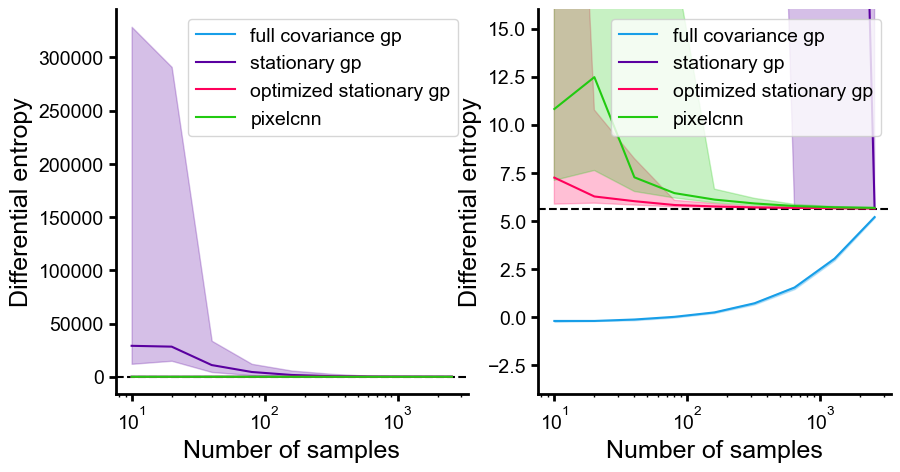

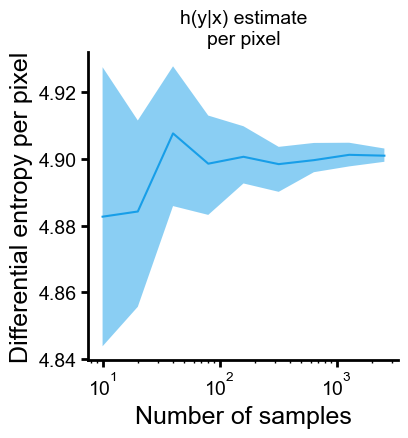

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax[0].axhline(h_y_analytic, color='k', linestyle='--')

colors = get_color_cycle()

ax[0].fill_between(num_samples_to_use, full_cov_h_y_estimates_conf_int[:,0], full_cov_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[0])
ax[0].semilogx(num_samples_to_use, full_cov_h_y_estimates_mean, label='full covariance gp', color=colors[0])
ax[0].fill_between(num_samples_to_use, stationary_h_y_estimates_conf_int[:,0], stationary_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[1])
ax[0].semilogx(num_samples_to_use, stationary_h_y_estimates_mean, label='stationary gp', color=colors[1])
ax[0].fill_between(num_samples_to_use, stationary_h_y_estimates_optimized_conf_int[:,0], stationary_h_y_estimates_optimized_conf_int[:,1], alpha=0.25, color=colors[2])
ax[0].semilogx(num_samples_to_use, stationary_h_y_estimates_optimized_mean, label='optimized stationary gp', color=colors[2])
ax[0].fill_between(num_samples_to_use, pixelcnn_h_y_estimates_conf_int[:,0], pixelcnn_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[3])
ax[0].semilogx(num_samples_to_use, pixelcnn_h_y_estimates_mean, label='pixelcnn', color=colors[3])

ax[0].set(xlabel='Number of samples', ylabel='Differential entropy')
ax[0].legend()
clear_spines(ax[0])

# Zoomed in
ax[1].axhline(h_y_analytic, color='k', linestyle='--')

ax[1].fill_between(num_samples_to_use, full_cov_h_y_estimates_conf_int[:,0], full_cov_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[0])
ax[1].semilogx(num_samples_to_use, full_cov_h_y_estimates_mean, label='full covariance gp', color=colors[0])
ax[1].fill_between(num_samples_to_use, stationary_h_y_estimates_conf_int[:,0], stationary_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[1])
ax[1].semilogx(num_samples_to_use, stationary_h_y_estimates_mean, label='stationary gp', color=colors[1])
ax[1].fill_between(num_samples_to_use, stationary_h_y_estimates_optimized_conf_int[:,0], stationary_h_y_estimates_optimized_conf_int[:,1], alpha=0.25, color=colors[2])
ax[1].semilogx(num_samples_to_use, stationary_h_y_estimates_optimized_mean, label='optimized stationary gp', color=colors[2])
ax[1].fill_between(num_samples_to_use, pixelcnn_h_y_estimates_conf_int[:,0], pixelcnn_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[3])
ax[1].semilogx(num_samples_to_use, pixelcnn_h_y_estimates_mean, label='pixelcnn', color=colors[3])

ax[1].set(xlabel='Number of samples', ylabel='Differential entropy')
ax[1].legend()
clear_spines(ax[1])
ax[1].set(ylim=(-4, 16))

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + 'entropy_estimation_consistency' + '.pdf', transparent=True)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.fill_between(num_samples_to_use, h_y_given_x_estimates_conf_int[:, 0], h_y_given_x_estimates_conf_int[:, 1], alpha=0.5)
ax.semilogx(num_samples_to_use, h_y_given_x_estimates_mean)
ax.set(xlabel='Number of samples', title='h(y|x) estimate\nper pixel', ylabel='Differential entropy per pixel')
clear_spines(ax)


fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + 'conditional_entropy_consistency' + '.pdf', transparent=True)